<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo11-conditional-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4

# Conditional GANs

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784).

## Libaries

As always, we load lots of libraries.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [ ]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [ ]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [ ]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [ ]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [ ]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [ ]:
images, labels = next(iter(data_loader))
y = labels.view(batch_size, 1)
y = to_onehot(y).to(DEVICE)
print(labels[:10])
print(y[:10])

tensor([7, 1, 9, 1, 1, 1, 5, 3, 3, 7])
tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], device='cuda:0')


In [ ]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y) # input includes labels
        D_x_loss = criterion(x_outputs, D_labels) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, D_fakes) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        G_loss = -1 * criterion(z_outputs, D_fakes) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.4041438102722168, G Loss: -0.6848204135894775
Epoch: 0/10, Step: 500, D Loss: 1.248561978340149, G Loss: -0.5364385843276978
Epoch: 1/10, Step: 1000, D Loss: 1.200400471687317, G Loss: -0.4087790250778198
Epoch: 1/10, Step: 1500, D Loss: 0.9095097780227661, G Loss: -0.4383925199508667
Epoch: 2/10, Step: 2000, D Loss: 1.1584500074386597, G Loss: -0.373153418302536
Epoch: 2/10, Step: 2500, D Loss: 1.1644258499145508, G Loss: -0.5376003980636597
Epoch: 3/10, Step: 3000, D Loss: 1.1516103744506836, G Loss: -0.6249410510063171
Epoch: 3/10, Step: 3500, D Loss: 1.2435364723205566, G Loss: -0.7233380079269409
Epoch: 4/10, Step: 4000, D Loss: 1.191441535949707, G Loss: -0.5706342458724976
Epoch: 4/10, Step: 4500, D Loss: 1.243701457977295, G Loss: -0.35075777769088745
Epoch: 5/10, Step: 5000, D Loss: 1.2693724632263184, G Loss: -0.6102859973907471
Epoch: 5/10, Step: 5500, D Loss: 1.1989004611968994, G Loss: -0.4149003326892853
Epoch: 6/10, Step: 6000, D Loss: 1.3

Now let's plot these images. At first, the generator just produces noise (as we expect).

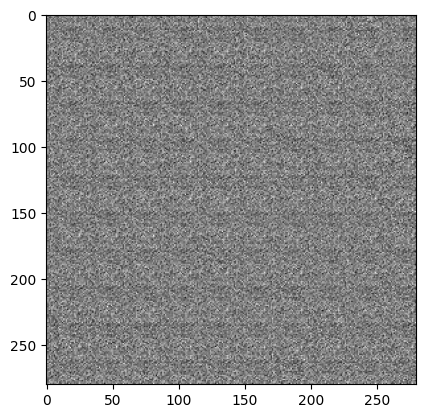

In [ ]:
img = mpimg.imread('samples/ConditionalGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

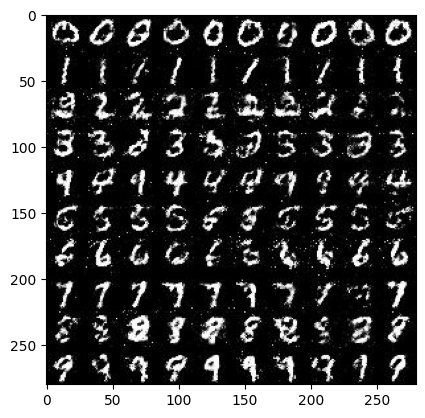

In [ ]:
img = mpimg.imread('samples/ConditionalGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

In fact, if we don't look too closely, we can recognize the numbers it produces.

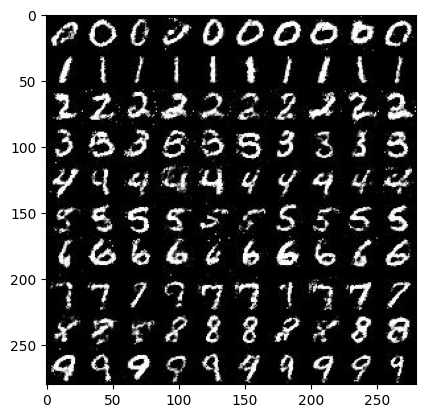

In [ ]:
img = mpimg.imread('samples/ConditionalGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

And by the time we're done training, even the worst images look like messy handwriting!

## GAN Quality Metrics

Here are several metrics to evaluate the quality of your trained conditional GAN:


In [ ]:
# A simple MNIST classifier to compare accuracies of real data vs generated data

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Train classifier
classifier = MNISTClassifier().to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

transform_classifier = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data/', train=True, transform=transform_classifier, download=False)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

classifier.train()
for epoch in range(3):  # Quick training
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = classifier(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')

# print("(Classification training code provided above - uncomment to use)")


Epoch 0, Batch 0, Loss: 2.3032
Epoch 0, Batch 100, Loss: 1.0339
Epoch 0, Batch 200, Loss: 0.8715
Epoch 0, Batch 300, Loss: 0.5330
Epoch 0, Batch 400, Loss: 0.5910
Epoch 0, Batch 500, Loss: 0.4017
Epoch 0, Batch 600, Loss: 0.4817
Epoch 0, Batch 700, Loss: 0.4985
Epoch 0, Batch 800, Loss: 0.3951
Epoch 0, Batch 900, Loss: 0.4842
Epoch 1, Batch 0, Loss: 0.2189
Epoch 1, Batch 100, Loss: 0.3892
Epoch 1, Batch 200, Loss: 0.3138
Epoch 1, Batch 300, Loss: 0.2849
Epoch 1, Batch 400, Loss: 0.3442
Epoch 1, Batch 500, Loss: 0.3579
Epoch 1, Batch 600, Loss: 0.1244
Epoch 1, Batch 700, Loss: 0.2078
Epoch 1, Batch 800, Loss: 0.3366
Epoch 1, Batch 900, Loss: 0.2949
Epoch 2, Batch 0, Loss: 0.2889
Epoch 2, Batch 100, Loss: 0.1268
Epoch 2, Batch 200, Loss: 0.2771
Epoch 2, Batch 300, Loss: 0.3822
Epoch 2, Batch 400, Loss: 0.1343
Epoch 2, Batch 500, Loss: 0.2111
Epoch 2, Batch 600, Loss: 0.1860
Epoch 2, Batch 700, Loss: 0.4410
Epoch 2, Batch 800, Loss: 0.5166
Epoch 2, Batch 900, Loss: 0.1730


In [ ]:
classifier.eval()
torch.save(classifier.state_dict(), 'simple_mnist_classifier/mnist_classifier.pth')
print("Classifier trained and saved!")

Classifier trained and saved!


In [ ]:
G.eval()
D.eval()

# Metric 1 : Let's see how well the Discriminator can tell apart real and fake data
def evaluate_discriminator_accuracy(D, G, data_loader, DEVICE, n_noise=100, num_samples=1000):

    correct_real = 0
    correct_fake = 0
    total_real = 0
    total_fake = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            if idx * batch_size >= num_samples:
                break

            # Real images
            x = images.to(DEVICE)
            y = labels.view(batch_size, 1)
            y_onehot = to_onehot(y).to(DEVICE)
            real_outputs = D(x, y_onehot)
            real_preds = (real_outputs > 0.5).float()
            correct_real += (real_preds == 1.0).sum().item()
            total_real += real_preds.size(0)

            # Fake images
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            fake_images = G(z, y_onehot)
            fake_outputs = D(fake_images, y_onehot)
            fake_preds = (fake_outputs < 0.5).float()
            correct_fake += (fake_preds == 1.0).sum().item()
            total_fake += fake_preds.size(0)

    real_acc = correct_real / total_real if total_real > 0 else 0
    fake_acc = correct_fake / total_fake if total_fake > 0 else 0
    overall_acc = (correct_real + correct_fake) / (total_real + total_fake) if (total_real + total_fake) > 0 else 0

    return real_acc, fake_acc, overall_acc

# Metric 2 : Using a simple trained MNIST classifer, we check the accuracy differences on real and generated data
def evaluate_classification_accuracy(G, DEVICE, n_noise=100, num_per_class=100):

    classifier = MNISTClassifier().to(DEVICE)
    classifier.load_state_dict(torch.load('simple_mnist_classifier/mnist_classifier.pth'))
    classifier.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for digit in range(10):
            y_onehot = torch.zeros(num_per_class, 10).to(DEVICE)
            y_onehot[:, digit] = 1
            z = torch.randn(num_per_class, n_noise).to(DEVICE)
            generated = G(z, y_onehot)

            # Normalize to [0, 1] for classifier (assuming classifier expects [0,1] not [-1,1])
            generated_normalized = (generated + 1) / 2.0
            outputs = classifier(generated_normalized)
            preds = outputs.argmax(dim=1)
            correct += (preds == digit).sum().item()
            total += num_per_class

    return correct / total if total > 0 else 0


# Metric 3 : Conditional Accuracy, herewe check if the generated image matches the requested class. We use the same simple classifier as above
def evaluate_conditional_accuracy(G, DEVICE, n_noise=100, num_per_class=50):

    classifier = MNISTClassifier().to(DEVICE)
    classifier.load_state_dict(torch.load('simple_mnist_classifier/mnist_classifier.pth'))
    classifier.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for digit in range(10):
            y_onehot = torch.zeros(num_per_class, 10).to(DEVICE)
            y_onehot[:, digit] = 1
            z = torch.randn(num_per_class, n_noise).to(DEVICE)
            generated = G(z, y_onehot)

            generated_normalized = (generated + 1) / 2.0
            outputs = classifier(generated_normalized)
            preds = outputs.argmax(dim=1)
            correct += (preds == digit).sum().item()
            total += num_per_class

    return correct / total if total > 0 else 0

# Metric 4 : we check if all the classes are being generated of if there is a mode collapse
def evaluate_mode_coverage(G, DEVICE, n_noise=100, num_per_class=100):

    classifier = MNISTClassifier().to(DEVICE)
    classifier.load_state_dict(torch.load('simple_mnist_classifier/mnist_classifier.pth'))
    classifier.eval()

    class_counts = {i: 0 for i in range(10)}

    with torch.no_grad():
        for digit in range(10):
            y_onehot = torch.zeros(num_per_class, 10).to(DEVICE)
            y_onehot[:, digit] = 1
            z = torch.randn(num_per_class, n_noise).to(DEVICE)
            generated = G(z, y_onehot)

            generated_normalized = (generated + 1) / 2.0
            outputs = classifier(generated_normalized)
            preds = outputs.argmax(dim=1)

            for pred in preds.cpu().numpy():
                class_counts[pred.item()] += 1

    return class_counts

print("GAN Quality Evaluation Functions Defined")


GAN Quality Evaluation Functions Defined


### Evaluation

In [ ]:
# Evaluate Discriminator Accuracy (this works without a classifier)
real_acc, fake_acc, overall_acc = evaluate_discriminator_accuracy(D, G, data_loader, DEVICE, n_noise)

print("GAN Quality Metrics Report")

print(f"[Discriminator Accuracy]")
print(f"Real Image Accuracy: {real_acc:.4f} ({real_acc*100:.2f}%)")
print(f"Fake Image Accuracy: {fake_acc:.4f} ({fake_acc*100:.2f}%)")
print(f"Overall Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
print(f"If both accuracies are around 0.5 that means discriminator can't tell real from fake")

print(f"\n2. Classification Accuracy:")

class_acc = evaluate_classification_accuracy(G, DEVICE, n_noise)
print(f"Classification Accuracy: {class_acc:.4f} ({class_acc*100:.2f}%)")
print(f"Interpretation: Percentage of generated images correctly classified as their target digit")

print(f"[Conditional Accuracy]")
cond_acc = evaluate_conditional_accuracy(G, DEVICE, n_noise)
print(f"Conditional Accuracy: {cond_acc:.4f} ({cond_acc*100:.2f}%)")
print(f"Interpretation: Percentage of generated images matching the requested class")
print(f"This is critical for conditional GANs - measures if generator respects the condition")

GAN Quality Metrics Report

1. Discriminator Accuracy:
   - Real Image Accuracy: 0.6826 (68.26%)
   - Fake Image Accuracy: 0.5059 (50.59%)
   - Overall Accuracy: 0.5942 (59.42%)

   Interpretation:
   - Ideal: Both accuracies around 0.5 (discriminator can't tell real from fake)
   - If real_acc >> 0.5: Generator needs improvement
   - If fake_acc >> 0.5: Discriminator is too weak

2. Classification Accuracy:
   - Classification Accuracy: 0.9580 (95.80%)
   - Interpretation: Percentage of generated images correctly classified as their target digit

3. Conditional Accuracy:
   - Conditional Accuracy: 0.9480 (94.80%)
   - Interpretation: Percentage of generated images matching the requested class
   - This is critical for conditional GANs - measures if generator respects the condition

4. Mode Coverage:
   - Classes Present: 10/10
   - Total Samples Generated: 1000
   - Class Distribution:
      Digit 0:  102 samples (10.20%)
      Digit 1:  100 samples (10.00%)
      Digit 2:   96 sample

---

# Standard GAN on FashionMNIST

A unconditioned or standard GAN implementation trained on FashionMNIST. Differences from conditional GAN:
- Generator only takes noise as input (no class labels)
- Discriminator only takes images as input (no class labels)

In [2]:
# Transform for FashionMNIST (same normalization as MNIST)
transform_fashion = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load FashionMNIST dataset
fashion_data = datasets.FashionMNIST(root='./fashionmnistdata/', train=True, transform=transform_fashion, download=True)

batch_size_gan = 64
fashion_loader = DataLoader(dataset=fashion_data, batch_size=batch_size_gan, shuffle=True, drop_last=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.9MB/s]


## Standard GAN Architecture

The generator takes only noise as input (no labels). The discriminator takes only images as input (no labels).


In [3]:
class StandardGenerator(nn.Module):
    """
    Standard GAN Generator - only takes noise as input (no labels)
    """
    def __init__(self, input_size=100, image_size=28*28):
        super(StandardGenerator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),  # No label concatenation
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        # Only noise input, no labels
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_


In [4]:
class StandardDiscriminator(nn.Module):
    """
    Standard GAN Discriminator - only takes images as input (no labels)
    """
    def __init__(self, input_size=28*28, num_output=1):
        super(StandardDiscriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),  # No label concatenation
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Only image input, no labels
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_


## Helper Function for Sampling

Since we can't control which class is generated, we'll just generate a grid of random samples.


In [5]:
def get_sample_image_standard(G, DEVICE, n_noise=100, grid_size=4):
    """
    Generate a grid of random images (no label control)
    """
    img = np.zeros([28*grid_size, 28*grid_size])
    z = torch.randn(grid_size*grid_size, n_noise).to(DEVICE)
    y_hat = G(z).view(grid_size*grid_size, 28, 28)
    result = y_hat.cpu().data.numpy()

    for i in range(grid_size):
        for j in range(grid_size):
            img[i*28:(i+1)*28, j*28:(j+1)*28] = result[i*grid_size + j]

    return img


## Setup and Training

Initialize models, optimizers, and training loop.

In [6]:
MODEL_NAME_STANDARD = 'StandardGAN'
DEVICE_STANDARD = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D_std = StandardDiscriminator().to(DEVICE_STANDARD)
G_std = StandardGenerator().to(DEVICE_STANDARD)

max_epoch_std = 10
step_std = 0
n_noise_std = 100  # size of noise vector

criterion_std = nn.BCELoss()
D_opt_std = torch.optim.Adam(D_std.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt_std = torch.optim.Adam(G_std.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels for discriminator (real=1, fake=0)
D_labels_std = torch.ones([batch_size_gan, 1]).to(DEVICE_STANDARD)  # Real images
D_fakes_std = torch.zeros([batch_size_gan, 1]).to(DEVICE_STANDARD)  # Fake images

print(f"Device: {DEVICE_STANDARD}")
print(f"Generator parameters: {sum(p.numel() for p in G_std.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in D_std.parameters()):,}")


Device: cuda:0
Generator parameters: 1,510,032
Discriminator parameters: 533,505


## Training Loop


In [7]:
if not os.path.exists('samples_standard'):
    os.makedirs('samples_standard')

for epoch in range(max_epoch_std):
    for idx, (images, labels) in enumerate(fashion_loader):
        x = images.to(DEVICE_STANDARD)
        x_outputs = D_std(x)
        D_x_loss = criterion_std(x_outputs, D_labels_std)

        z = torch.randn(batch_size_gan, n_noise_std).to(DEVICE_STANDARD)
        z_outputs = D_std(G_std(z))
        D_z_loss = criterion_std(z_outputs, D_fakes_std)
        D_loss_std = D_x_loss + D_z_loss

        D_std.zero_grad()
        D_loss_std.backward()
        D_opt_std.step()

        # Training Generator
        z = torch.randn(batch_size_gan, n_noise_std).to(DEVICE_STANDARD)
        z_outputs = D_std(G_std(z))
        G_loss_std = criterion_std(z_outputs, D_labels_std)

        G_std.zero_grad()
        G_loss_std.backward()
        G_opt_std.step()

        if step_std % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}'.format(
                epoch, max_epoch_std, step_std, D_loss_std.item(), G_loss_std.item()))

        if step_std % 1000 == 0:
            G_std.eval()
            img = get_sample_image_standard(G_std, DEVICE_STANDARD, n_noise_std)
            imsave('samples_standard/{}_step{}.jpg'.format(MODEL_NAME_STANDARD, str(step_std).zfill(3)),
                   img)
            G_std.train()
        step_std += 1


Epoch: 0/10, Step: 0, D Loss: 1.3961, G Loss: 0.7038
Epoch: 0/10, Step: 500, D Loss: 1.1978, G Loss: 0.8006
Epoch: 1/10, Step: 1000, D Loss: 1.3273, G Loss: 0.8850
Epoch: 1/10, Step: 1500, D Loss: 1.3290, G Loss: 1.1276
Epoch: 2/10, Step: 2000, D Loss: 1.3103, G Loss: 0.9808
Epoch: 2/10, Step: 2500, D Loss: 1.2980, G Loss: 1.0809
Epoch: 3/10, Step: 3000, D Loss: 1.3113, G Loss: 0.8812
Epoch: 3/10, Step: 3500, D Loss: 1.3345, G Loss: 0.8729
Epoch: 4/10, Step: 4000, D Loss: 1.3789, G Loss: 0.8510
Epoch: 4/10, Step: 4500, D Loss: 1.2640, G Loss: 0.8941
Epoch: 5/10, Step: 5000, D Loss: 1.2549, G Loss: 0.9692
Epoch: 5/10, Step: 5500, D Loss: 1.3278, G Loss: 0.9638
Epoch: 6/10, Step: 6000, D Loss: 1.4170, G Loss: 0.8316
Epoch: 6/10, Step: 6500, D Loss: 1.4108, G Loss: 0.7676
Epoch: 7/10, Step: 7000, D Loss: 1.4241, G Loss: 0.7062
Epoch: 8/10, Step: 7500, D Loss: 1.3546, G Loss: 0.7470
Epoch: 8/10, Step: 8000, D Loss: 1.3404, G Loss: 1.0398
Epoch: 9/10, Step: 8500, D Loss: 1.3148, G Loss: 0.8

## Visualizing Results

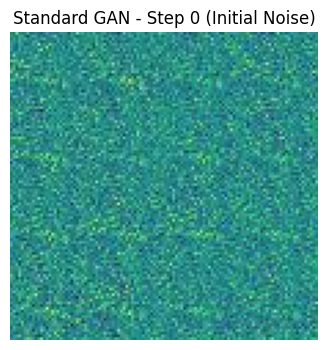

In [8]:
# Initial generation (should be noise)
img = mpimg.imread('samples_standard/StandardGAN_step000.jpg')
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title('Standard GAN - Step 0 (Initial Noise)')
plt.axis('off')
plt.show()


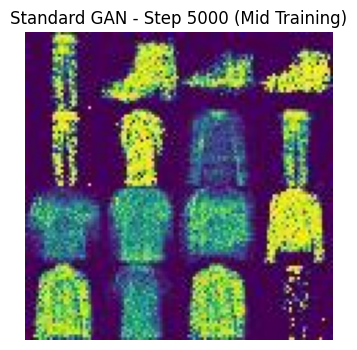

In [9]:
# Mid-training generation
try:
    img = mpimg.imread('samples_standard/StandardGAN_step5000.jpg')
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title('Standard GAN - Step 5000 (Mid Training)')
    plt.axis('off')
    plt.show()
except:
    print("Step 5000 image not yet generated. Continue training or check available step numbers.")


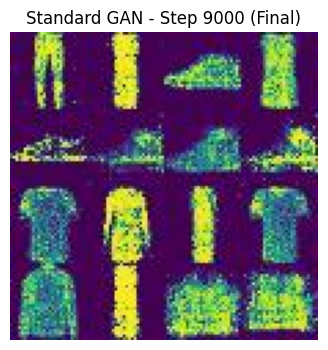

In [10]:
# Final generation
try:
    img = mpimg.imread('samples_standard/StandardGAN_step9000.jpg')
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title('Standard GAN - Step 9000 (Final)')
    plt.axis('off')
    plt.show()
except:
    print("Step 9000 image not yet generated. Continue training or check available step numbers.")


## Standard GAN Quality Metrics

Here are evaluation metrics for the standard GAN:


In [15]:
G_std.eval()
D_std.eval()

# Metric 1 : Discriminator Accuracy Metrics
def evaluate_discriminator_accuracy_standard(D, G, data_loader, DEVICE, n_noise=100, num_samples=1000):

    correct_real = 0
    correct_fake = 0
    total_real = 0
    total_fake = 0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            if idx * batch_size_gan >= num_samples:
                break

            x = images.to(DEVICE)
            real_outputs = D(x)
            real_preds = (real_outputs > 0.5).float()
            correct_real += (real_preds == 1.0).sum().item()
            total_real += real_preds.size(0)

            z = torch.randn(batch_size_gan, n_noise).to(DEVICE)
            fake_images = G(z)
            fake_outputs = D(fake_images)
            fake_preds = (fake_outputs < 0.5).float()
            correct_fake += (fake_preds == 1.0).sum().item()
            total_fake += fake_preds.size(0)

    real_acc = correct_real / total_real if total_real > 0 else 0
    fake_acc = correct_fake / total_fake if total_fake > 0 else 0
    overall_acc = (correct_real + correct_fake) / (total_real + total_fake) if (total_real + total_fake) > 0 else 0

    return real_acc, fake_acc, overall_acc

# metric 2 : Classification Accuracy using a simple trained Classification Convolutional NN, trained later
def evaluate_classification_accuracy_standard(G, DEVICE, n_noise=100, num_samples=1000):

    classifier = FashionMNISTClassifier().to(DEVICE)
    classifier.load_state_dict(torch.load('fashionmnist_classifier/fashionmnist_classifier.pth'))
    classifier.eval()

    correct = 0
    total = 0
    class_counts = {i: 0 for i in range(10)}

    with torch.no_grad():
        num_batches = (num_samples + batch_size_gan - 1) // batch_size_gan
        for _ in range(num_batches):
            z = torch.randn(batch_size_gan, n_noise).to(DEVICE)
            generated = G(z)

            generated_normalized = (generated + 1) / 2.0
            outputs = classifier(generated_normalized)
            preds = outputs.argmax(dim=1)

            for pred in preds.cpu().numpy():
                class_counts[pred.item()] += 1

            total += preds.size(0)
            if total >= num_samples:
                break

    return class_counts, total

# Metric 3 : Here we check if every class is being fairly equally generated or not (Mode coverage)
def evaluate_mode_coverage_standard(G, DEVICE, n_noise=100, num_samples=1000):

    classifier = FashionMNISTClassifier().to(DEVICE)
    classifier.load_state_dict(torch.load('fashionmnist_classifier/fashionmnist_classifier.pth'))
    classifier.eval()

    class_counts = {i: 0 for i in range(10)}
    fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    with torch.no_grad():
        num_batches = (num_samples + batch_size_gan - 1) // batch_size_gan
        for _ in range(num_batches):
            z = torch.randn(batch_size_gan, n_noise).to(DEVICE)
            generated = G(z)

            generated_normalized = (generated + 1) / 2.0
            outputs = classifier(generated_normalized)
            preds = outputs.argmax(dim=1)

            for pred in preds.cpu().numpy():
                class_counts[pred.item()] += 1

    return class_counts, fashion_classes

# Metric 4 : Diversity (Pixel-level metrics)
def evaluate_diversity_standard(G, DEVICE, n_noise=100, num_samples=100):
    """
    Calculate diversity metrics based on pixel-level differences.
    Uses average pairwise distance and pixel variance.

    Args:
        G: Generator model
        DEVICE: Device to run on
        n_noise: Noise vector size
        num_samples: Number of samples to generate for evaluation

    Returns:
        Dictionary with diversity metrics
    """
    from scipy.spatial.distance import pdist

    G.eval()
    generated_images = []

    with torch.no_grad():
        num_batches = (num_samples + batch_size_gan - 1) // batch_size_gan
        for _ in range(num_batches):
            z = torch.randn(batch_size_gan, n_noise).to(DEVICE)
            generated = G(z)

            # Convert to numpy and normalize to [0, 1]
            generated_np = generated.cpu().squeeze().numpy()
            # Denormalize from [-1, 1] to [0, 1]
            generated_np = (generated_np + 1) / 2.0
            generated_np = np.clip(generated_np, 0, 1)

            generated_images.extend(generated_np)

            if len(generated_images) >= num_samples:
                generated_images = generated_images[:num_samples]
                break

    # Convert to numpy array
    generated_images = np.array(generated_images)

    # Flatten images to vectors for distance calculation
    flattened = generated_images.reshape(len(generated_images), -1)

    # Calculate pairwise L2 distances
    distances = pdist(flattened, metric='euclidean')
    avg_pairwise_distance = np.mean(distances)

    # Calculate pixel variance across samples
    pixel_variance = np.var(generated_images, axis=0).mean()

    return {
        'avg_pairwise_distance': avg_pairwise_distance,
        'pixel_variance': pixel_variance
    }

# Metric 5 : Sharpness
def evaluate_sharpness_standard(G, DEVICE, n_noise=100, num_samples=100):
    """
    Calculate sharpness metrics for generated images using Laplacian variance and gradient magnitude.
    Higher values indicate sharper images.

    Args:
        G: Generator model
        DEVICE: Device to run on
        n_noise: Noise vector size
        num_samples: Number of samples to generate for evaluation

    Returns:
        Dictionary with sharpness metrics
    """
    from scipy.ndimage import laplace, sobel

    G.eval()
    sharpness_scores_laplacian = []
    sharpness_scores_gradient = []

    with torch.no_grad():
        num_batches = (num_samples + batch_size_gan - 1) // batch_size_gan
        for _ in range(num_batches):
            z = torch.randn(batch_size_gan, n_noise).to(DEVICE)
            generated = G(z)

            # Convert to numpy and normalize to [0, 1]
            generated_np = generated.cpu().squeeze().numpy()
            # Denormalize from [-1, 1] to [0, 1]
            generated_np = (generated_np + 1) / 2.0
            generated_np = np.clip(generated_np, 0, 1)

            # Calculate sharpness for each image in batch
            for img in generated_np:
                # Normalize to 0-255 range for better sharpness calculation
                img_uint8 = (img * 255).astype(np.float64)

                # Method 1: Laplacian variance (most common sharpness metric)
                laplacian_img = laplace(img_uint8)
                laplacian_var = np.var(laplacian_img)
                sharpness_scores_laplacian.append(laplacian_var)

                # Method 2: Gradient magnitude using Sobel operator
                grad_x = sobel(img_uint8, axis=1)
                grad_y = sobel(img_uint8, axis=0)
                gradient_mag = np.sqrt(grad_x**2 + grad_y**2).mean()
                sharpness_scores_gradient.append(gradient_mag)

            if len(sharpness_scores_laplacian) >= num_samples:
                break

    # Calculate statistics
    laplacian_mean = np.mean(sharpness_scores_laplacian)
    laplacian_std = np.std(sharpness_scores_laplacian)
    gradient_mean = np.mean(sharpness_scores_gradient)
    gradient_std = np.std(sharpness_scores_gradient)

    return {
        'laplacian_variance_mean': laplacian_mean,
        'laplacian_variance_std': laplacian_std,
        'gradient_magnitude_mean': gradient_mean,
        'gradient_magnitude_std': gradient_std
    }

# Helper function to calculate sharpness for real data
def evaluate_sharpness_real_data(data_loader, DEVICE, num_samples=100):
    """
    Calculate sharpness metrics for real data images.

    Args:
        data_loader: DataLoader with real images
        DEVICE: Device to run on
        num_samples: Number of samples to evaluate

    Returns:
        Dictionary with sharpness metrics
    """
    from scipy.ndimage import laplace, sobel

    sharpness_scores_laplacian = []
    sharpness_scores_gradient = []

    sample_count = 0
    with torch.no_grad():
        for images, labels in data_loader:
            # Convert to numpy and normalize to [0, 1]
            # Images are already normalized to [-1, 1] from transform
            images_np = images.cpu().squeeze().numpy()
            images_np = (images_np + 1) / 2.0
            images_np = np.clip(images_np, 0, 1)

            # Calculate sharpness for each image in batch
            for img in images_np:
                # Normalize to 0-255 range for better sharpness calculation
                img_uint8 = (img * 255).astype(np.float64)

                # Method 1: Laplacian variance
                laplacian_img = laplace(img_uint8)
                laplacian_var = np.var(laplacian_img)
                sharpness_scores_laplacian.append(laplacian_var)

                # Method 2: Gradient magnitude using Sobel operator
                grad_x = sobel(img_uint8, axis=1)
                grad_y = sobel(img_uint8, axis=0)
                gradient_mag = np.sqrt(grad_x**2 + grad_y**2).mean()
                sharpness_scores_gradient.append(gradient_mag)

                sample_count += 1
                if sample_count >= num_samples:
                    break

            if sample_count >= num_samples:
                break

    # Calculate statistics
    laplacian_mean = np.mean(sharpness_scores_laplacian)
    laplacian_std = np.std(sharpness_scores_laplacian)
    gradient_mean = np.mean(sharpness_scores_gradient)
    gradient_std = np.std(sharpness_scores_gradient)

    return {
        'laplacian_variance_mean': laplacian_mean,
        'laplacian_variance_std': laplacian_std,
        'gradient_magnitude_mean': gradient_mean,
        'gradient_magnitude_std': gradient_std
    }

In [13]:
# Training FashionMNIST classifier for evaluations

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)  # 10 classes for FashionMNIST

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Train classifier
classifier = FashionMNISTClassifier().to(DEVICE_STANDARD)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

transform_classifier = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./fashionmnistdata/', train=True, transform=transform_classifier, download=False)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

classifier.train()
for epoch in range(3):  # Quick training
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE_STANDARD), target.to(DEVICE_STANDARD)
        optimizer.zero_grad()
        output = classifier(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')

Epoch 0, Batch 0, Loss: 2.3039
Epoch 0, Batch 100, Loss: 1.2123
Epoch 0, Batch 200, Loss: 1.2654
Epoch 0, Batch 300, Loss: 0.8748
Epoch 0, Batch 400, Loss: 0.7898
Epoch 0, Batch 500, Loss: 0.6056
Epoch 0, Batch 600, Loss: 0.6459
Epoch 0, Batch 700, Loss: 1.0009
Epoch 0, Batch 800, Loss: 0.6943
Epoch 0, Batch 900, Loss: 0.7099
Epoch 1, Batch 0, Loss: 0.6518
Epoch 1, Batch 100, Loss: 0.8250
Epoch 1, Batch 200, Loss: 0.6212
Epoch 1, Batch 300, Loss: 0.5363
Epoch 1, Batch 400, Loss: 0.7111
Epoch 1, Batch 500, Loss: 0.7288
Epoch 1, Batch 600, Loss: 0.8191
Epoch 1, Batch 700, Loss: 0.8548
Epoch 1, Batch 800, Loss: 0.5489
Epoch 1, Batch 900, Loss: 0.4847
Epoch 2, Batch 0, Loss: 0.4646
Epoch 2, Batch 100, Loss: 0.4535
Epoch 2, Batch 200, Loss: 0.4247
Epoch 2, Batch 300, Loss: 0.4744
Epoch 2, Batch 400, Loss: 0.6789
Epoch 2, Batch 500, Loss: 0.5488
Epoch 2, Batch 600, Loss: 0.4676
Epoch 2, Batch 700, Loss: 0.5729
Epoch 2, Batch 800, Loss: 0.5973
Epoch 2, Batch 900, Loss: 0.6177
FashionMNIST Cla

In [ ]:
classifier.eval()
torch.save(classifier.state_dict(), 'fashionmnist_classifier/fashionmnist_classifier.pth')
print("FashionMNIST Classifier trained and saved!")

### Evaluation


In [16]:
# Evaluation for fashionmnist

# Load trained classifier
classifier = FashionMNISTClassifier().to(DEVICE_STANDARD)
classifier.load_state_dict(torch.load('fashionmnist_classifier/fashionmnist_classifier.pth'))
classifier.eval()

# Evaluate discriminator accuracy
real_acc_std, fake_acc_std, overall_acc_std = evaluate_discriminator_accuracy_standard(
    D_std, G_std, fashion_loader, DEVICE_STANDARD, n_noise_std, num_samples=1000)

# Evaluate diversity
diversity_metrics = evaluate_diversity_standard(
    G_std, DEVICE_STANDARD, n_noise_std, num_samples=100)

# Evaluate sharpness for generated data
sharpness_metrics = evaluate_sharpness_standard(
    G_std, DEVICE_STANDARD, n_noise_std, num_samples=100)

# Evaluate sharpness for real data
sharpness_metrics_real = evaluate_sharpness_real_data(
    fashion_loader, DEVICE_STANDARD, num_samples=100)

print("=" * 60)
print("Standard GAN Full Quality Metrics Report")
print("=" * 60)
print(f"[Discriminator Accuracy]")
print(f"Real Image Accuracy: {real_acc_std:.4f} ({real_acc_std*100:.2f}%)")
print(f"Fake Image Accuracy: {fake_acc_std:.4f} ({fake_acc_std*100:.2f}%)")
print(f"Overall Accuracy: {overall_acc_std:.4f} ({overall_acc_std*100:.2f}%)")

print(f"\n{'=' * 50}")
print("DIVERSITY METRICS")
print(f"{'=' * 50}")
print(f"Average Pairwise Distance: {diversity_metrics['avg_pairwise_distance']:.4f}")
print(f"Pixel Variance: {diversity_metrics['pixel_variance']:.6f}")

print(f"\n[Sharpness Metrics]")
print(f"Laplacian Variance (mean): {sharpness_metrics['laplacian_variance_mean']:.4f}")
print(f"Laplacian Variance (std): {sharpness_metrics['laplacian_variance_std']:.4f}")
print(f"Gradient Magnitude (mean): {sharpness_metrics['gradient_magnitude_mean']:.4f}")
print(f"Gradient Magnitude (std): {sharpness_metrics['gradient_magnitude_std']:.4f}")

print(f"\n{'=' * 50}")
print("COMPARISON WITH REAL DATA")
print(f"{'=' * 50}")
print(f"Real Data - Laplacian Variance: {sharpness_metrics_real['laplacian_variance_mean']:.4f}")
print(f"Real Data - Gradient Magnitude: {sharpness_metrics_real['gradient_magnitude_mean']:.4f}")
print(f"Generated Data - Laplacian Variance: {sharpness_metrics['laplacian_variance_mean']:.4f}")
print(f"Generated Data - Gradient Magnitude: {sharpness_metrics['gradient_magnitude_mean']:.4f}")

print("\nA high diversity (close to 1) is ideal")

Standard GAN Full Quality Metrics Report
[Discriminator Accuracy]
Real Image Accuracy: 0.5156 (51.56%)
Fake Image Accuracy: 0.7266 (72.66%)
Overall Accuracy: 0.6211 (62.11%)

DIVERSITY METRICS
Average Pairwise Distance: 10.9312
Pixel Variance: 0.081251

[Sharpness Metrics]
Laplacian Variance (mean): 21187.2653
Laplacian Variance (std): 8458.7522
Gradient Magnitude (mean): 199.3631
Gradient Magnitude (std): 47.9669

COMPARISON WITH REAL DATA
Real Data - Laplacian Variance: 10494.1808
Real Data - Gradient Magnitude: 178.0507
Generated Data - Laplacian Variance: 21187.2653
Generated Data - Gradient Magnitude: 199.3631

A high diversity (close to 1) is ideal


References :
- chatgpt.com : for refining the code and some explanations
- https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid
